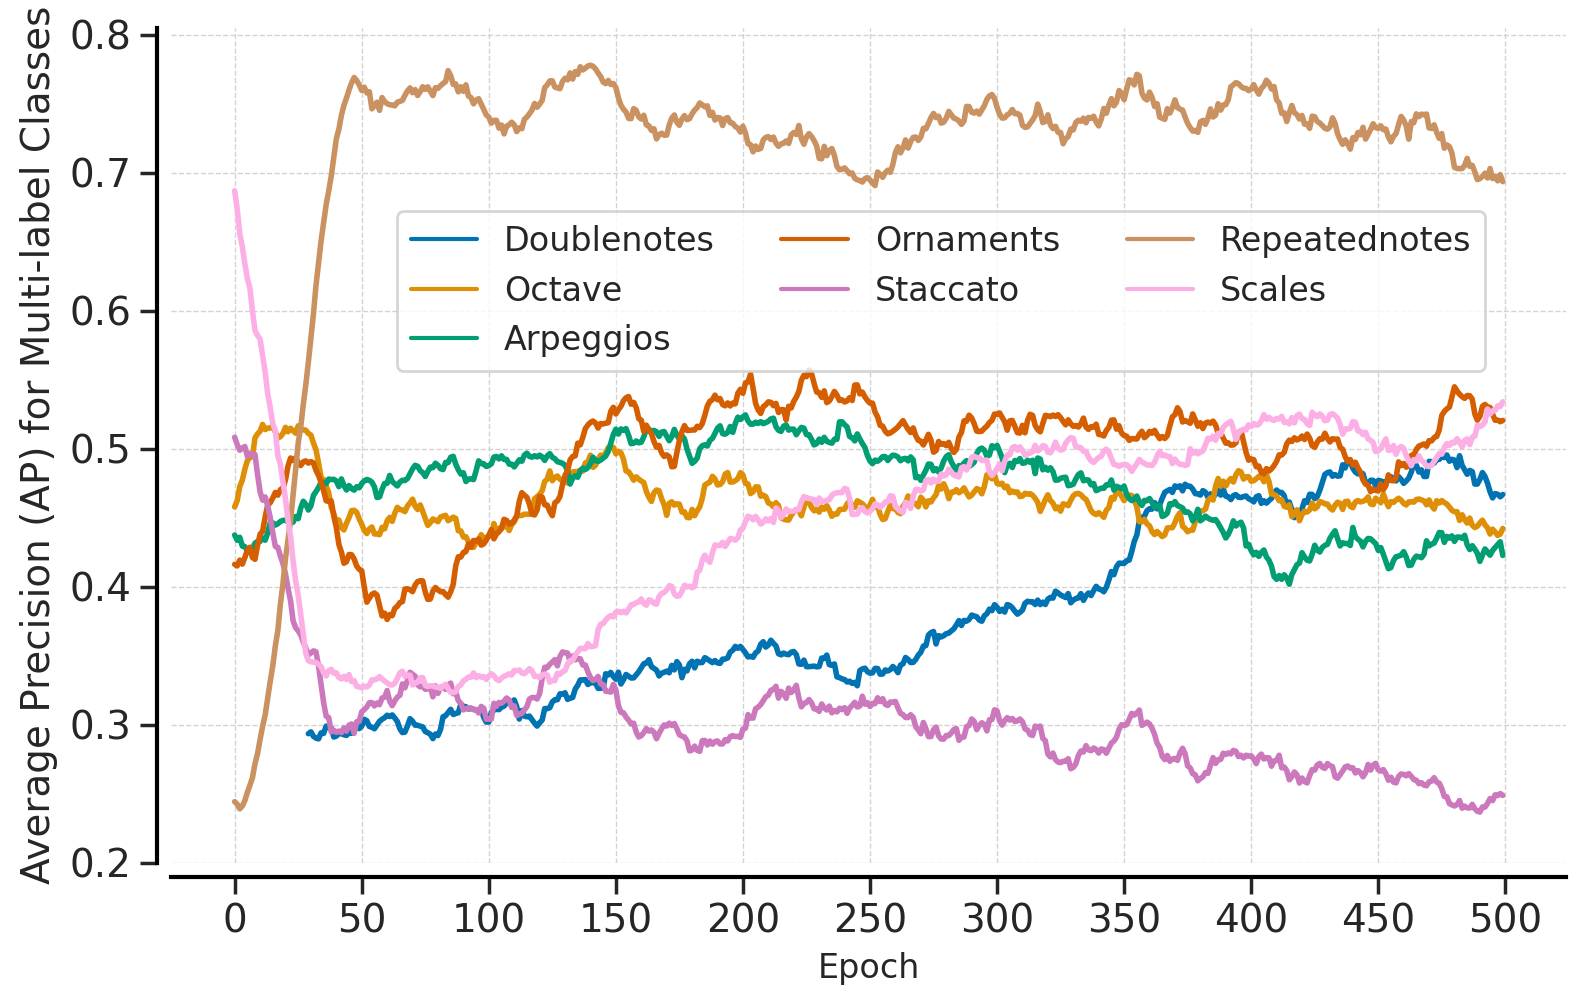

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# plt.rcParams.update({'font.size': 100})


plt.rc('font', family='sans-serif')
sns.set_palette('colorblind')

# Load the data
df = pd.read_csv('ap_class.csv')

# Reshape the dataframe to have 'epoch', 'AP', and 'Class' columns
df_long = df.melt(id_vars=['epoch'], 
                  value_vars=['technique_spec_m_7_nt - valAP/Doublenotes', 
                              'technique_spec_m_7_nt - valAP/Octave',
                              'technique_spec_m_7_nt - valAP/Arpeggios',
                              'technique_spec_m_7_nt - valAP/Ornaments',
                              'technique_spec_m_7_nt - valAP/Staccato',
                              'technique_spec_m_7_nt - valAP/Repeatednotes',
                              'technique_spec_m_7_nt - valAP/Scales'],
                  var_name='Class', 
                  value_name='AP')

# apply smoothing to the lines
df_long['AP'] = df_long['AP'].rolling(30).mean()

# replace legend name to be shorter
df_long['Class'] = df_long['Class'].replace({'technique_spec_m_7_nt - valAP/Doublenotes': 'Doublenotes',
                                             'technique_spec_m_7_nt - valAP/Octave': 'Octave',
                                             'technique_spec_m_7_nt - valAP/Arpeggios': 'Arpeggios',
                                             'technique_spec_m_7_nt - valAP/Ornaments': 'Ornaments',
                                             'technique_spec_m_7_nt - valAP/Staccato': 'Staccato',
                                             'technique_spec_m_7_nt - valAP/Repeatednotes': 'Repeatednotes',
                                             'technique_spec_m_7_nt - valAP/Scales': 'Scales'})

# Extract the class names to a new column for legend labeling
df_long['Class'] = df_long['Class'].str.replace('technique_jukebox_m_7_nt - valAP/', '')

# Now create the plot
sns.set_theme(style='whitegrid', rc={
    'xtick.bottom': True,
    'ytick.left': True,
})
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi = 200)
ax.grid(False)
ax.tick_params(axis='both', which='major', labelsize=14)


ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

#black outside borders
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

## move the left and bottom spines slightly left and down
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))

plt.tight_layout()

sns.lineplot(data=df_long, x='epoch', y='AP', hue='Class', dashes=True, style=None, ax=ax, palette='colorblind', markersize=5, markeredgecolor='w', alpha = 1, markeredgewidth=-12, markers=['o'], linewidth = 2)

ax.set_xticks(range(0, 501, 50))
ax.set_yticks(np.arange(0.2, 0.8, 0.1))

# plt.title('Average Precision (AP) for Each Class')
plt.xlabel('Epoch')
plt.ylabel('Average Precision (AP) for Multi-label Classes', fontsize=14)
plt.legend(title='Class Labels')

# Adjust the legend to avoid overlapping with the plot
plt.legend(
    bbox_to_anchor=(0.15, 0.8), 
    ncols=3, loc='upper left', fontsize=12)

# light gray grid with 0.5 width dashes line
ax.grid(color='lightgray', linestyle='--', linewidth=0.5)


plt.show()

/tmp/ipykernel_183096/238068816.py:77: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(plot_data, x='threshold', y='accuracy', dashes=True, style=None, ax=ax, palette='magma', markersize=5, markeredgecolor='w', alpha = 1, legend=False, markeredgewidth=-12, markers=['o'], linewidth = 2)


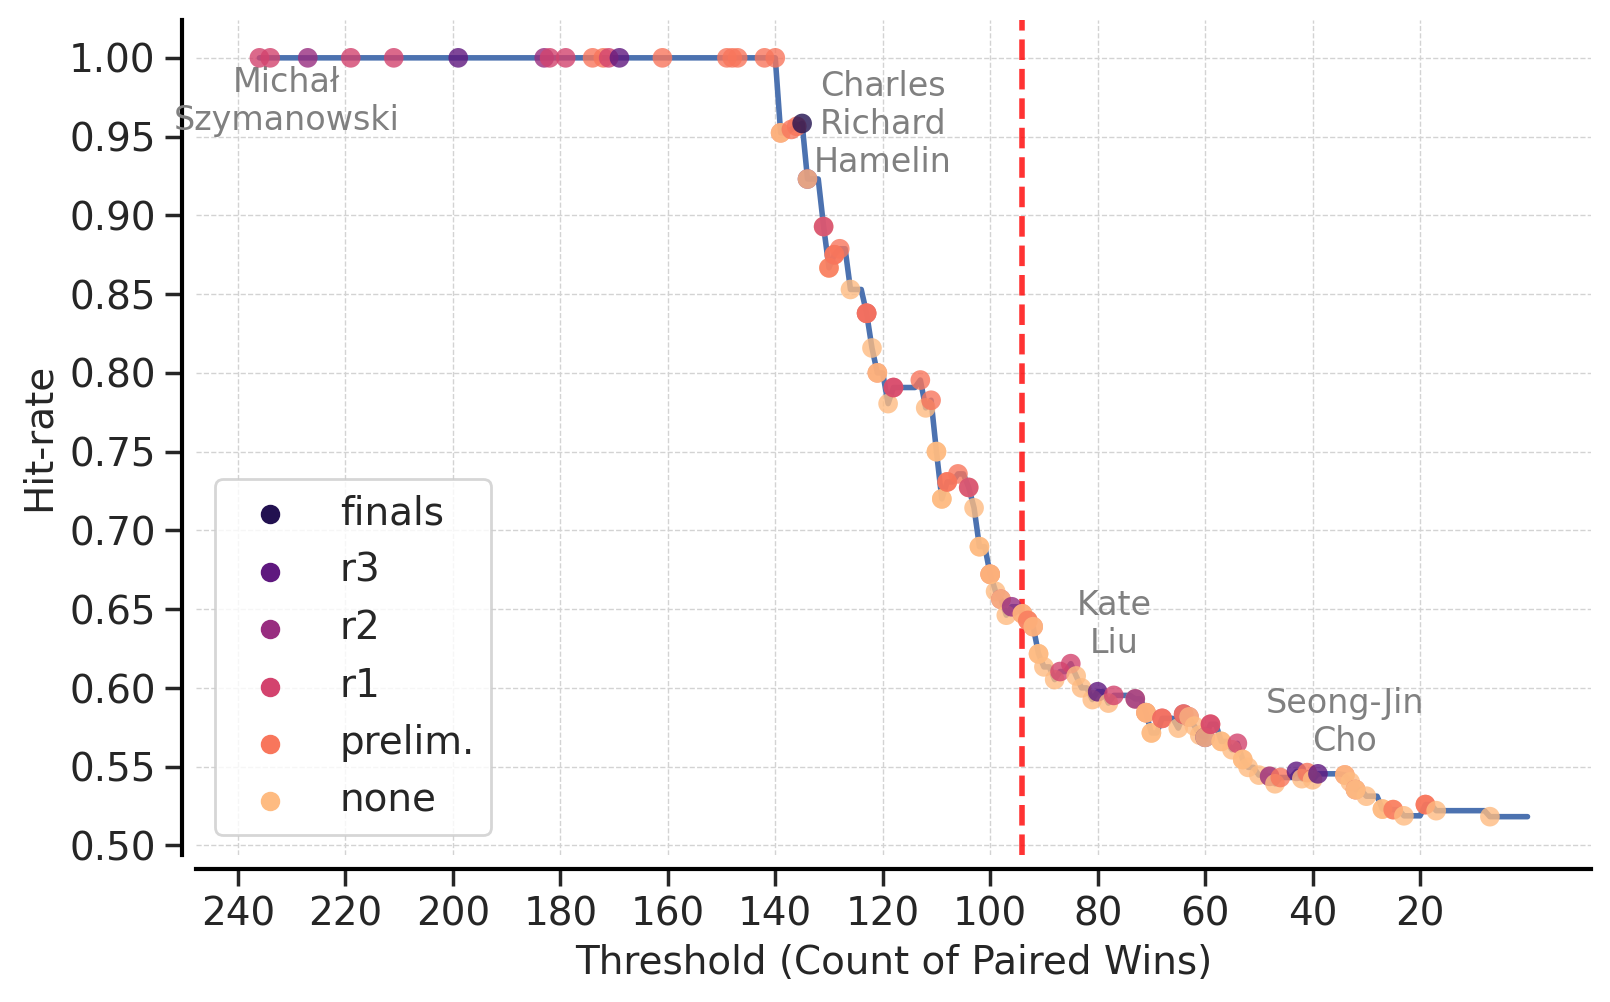

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

plt.rc('font', family='sans-serif')
sns.set_palette('colorblind')

# Load the data
pred_df = pd.read_csv('../rank_counts.csv')
gt_df = pd.read_csv("/import/c4dm-scratch-02/ICPC2015-dataset/data/results.tsv", delimiter="\t")
gt_df['name'] = gt_df['name'].str.strip()
# Merge the prediction data with the ground truth data
pred_df = pred_df.merge(gt_df, on='name')

# Define the tiers as a list of column names, ordered from lowest to highest
tiers = ['preliminary', 'r1', '2', '3', 'finals']
tiers_reversed = tiers[::-1]

# Define a function to find the highest tier reached by a candidate
def find_highest_tier(row):
    for tier in tiers_reversed:
        if row[tier] == 1:
            return tier
    return 'none'

# Apply the function to each row
pred_df['tier'] = pred_df.apply(find_highest_tier, axis=1)
pred_df['tier'] = pred_df['tier'].replace({'r1': 'r1', '2': 'r2', '3': 'r3', 'finals': 'finals', 'preliminary': 'prelim.'})

# Determine the range of possible count thresholds
thresholds = np.arange(0, pred_df['counts'].max() + 1, 1)  # Adjust the step if necessary

# Calculate accuracy at each threshold
accuracies = []
for threshold in thresholds:
    
    # Predict pass if counts are greater than or equal to threshold
    pred_pass =  pred_df[pred_df['counts'] >= threshold]
    pred_gt = gt_df[gt_df['name'].isin(pred_pass['name'])]
    # Calculate accuracy
    accuracy = (pred_gt['preliminary']).mean()
    accuracies.append(accuracy)

plot_data = pd.DataFrame({'threshold': thresholds, 'accuracy': accuracies})

acc_curve = interp1d(thresholds, accuracies)
candidates = pd.DataFrame({'name': pred_df['name'], 'counts': pred_df['counts'], 'y': acc_curve(pred_df['counts']), 'tier': pred_df['tier'] }  )

# Plot threshold vs. accuracy
sns.set_theme(style='whitegrid', rc={
    'xtick.bottom': True,
    'ytick.left': True,
})
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi = 200)
ax.grid(False)
ax.tick_params(axis='both', which='major', labelsize=14)

ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

#black outside borders
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

## move the left and bottom spines slightly left and down
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))

plt.tight_layout()

# plt.plot(thresholds, accuracies, marker='o')
sns.lineplot(plot_data, x='threshold', y='accuracy', dashes=True, style=None, ax=ax, palette='magma', markersize=5, markeredgecolor='w', alpha = 1, legend=False, markeredgewidth=-12, markers=['o'], linewidth = 2)
sns.scatterplot(data=candidates, x='counts', y='y', 
                hue='tier', hue_order=['finals', 'r3', 'r2', 'r1', 'prelim.', 'none'],
                style=None, ax=ax, palette='magma', s=50, markers=['D', 'o'], edgecolor='k', linewidth=0, alpha=0.8, zorder=10)

plt.axvline(94, 0, 1, color='red', linestyle='--', linewidth=2, alpha=0.8)

x_offsets = [-5, -14, -3, -5]
y_offsets = [-0.05, 0, 0.02, 0.01]
for i, cand in enumerate(['Michał Szymanowski', 'Charles Richard Hamelin', 'Kate Liu', 'Seong-Jin Cho',]):
    found_cand = candidates[candidates['name'] == cand].squeeze()
    ax.text(found_cand['counts']+x_offsets[i], found_cand['y']+y_offsets[i], found_cand['name'].replace(" ", "\n"), ha='center', va='bottom', fontsize=12, color='gray', alpha=1)


ax.set_xticks(range(240, 0, -20))
ax.set_yticks(np.arange(0.5, 1.01, 0.05))
ax.invert_xaxis()

# plt.title('Threshold vs. Hit-rate for Preliminary Round Pass Prediction', fontsize=14)
plt.xlabel('Threshold (Count of Paired Wins)', fontsize=14)
plt.ylabel('Hit-rate', fontsize=14)

# Adjust the legend to avoid overlapping with the plot
plt.legend(
    # bbox_to_anchor=(0.15, 0.8), 
    loc='lower left', fontsize=14)

# light gray grid with 0.5 width dashes line
ax.grid(color='lightgray', linestyle='--', linewidth=0.5)

plt.show()

